# 경구약제 이미지 객체 검출(Object Detection) 프로젝트

데이터 구글 드라이브에서 불러오기

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os

project_path = '/content/drive/MyDrive/초급 프로젝트 데이터 모음'
os.chdir(project_path)

print("현재 디렉토리:", os.getcwd())

Mounted at /content/drive
현재 디렉토리: /content/drive/MyDrive/초급 프로젝트 데이터 모음


##1. 데이터 전처리(데이터 수집, 데이터 정제)

전체 폴더 구조 확인

In [ ]:
import os
from collections import defaultdict

def analyze_directory(path, name=""):
    print(f"\n [{name}] - 경로: {path}")

    if not os.path.exists(path):
        print(" 존재하지 않음")
        return

    all_files = []
    file_ext_counter = defaultdict(int)

    for root, _, files in os.walk(path):
        for file in files:
            all_files.append(os.path.join(root, file))
            ext = os.path.splitext(file)[1].lower()
            file_ext_counter[ext] += 1

    print(f"총 파일 수: {len(all_files)}")
    print("파일 확장자 분포:")
    for ext, count in file_ext_counter.items():
        print(f"  - {ext or '[no extension]'}: {count}개")

    print("샘플:")
    for f in all_files[:5]:
        print(f"  └ {f}")

# 디렉토리 경로 설정
train_images_path = './train_images'
test_images_path = './test_images'
train_annots_path = './train_annotations'

# 분석 실행
analyze_directory(train_images_path, name="Train Images")
analyze_directory(test_images_path, name="Test Images")
analyze_directory(train_annots_path, name="Train Annotations (including subfolders)")



 [Train Images] - 경로: ./train_images
총 파일 수: 1489
파일 확장자 분포:
  - .png: 1489개
샘플:
  └ ./train_images/K-003351-003832-035206_0_2_0_2_70_000_200.png
  └ ./train_images/K-003351-013900-035206_0_2_0_2_75_000_200.png
  └ ./train_images/K-003351-013900-036637_0_2_0_2_75_000_200.png
  └ ./train_images/K-003351-016232-018357_0_2_0_2_75_000_200.png
  └ ./train_images/K-003351-013900-038162_0_2_0_2_75_000_200.png

 [Test Images] - 경로: ./test_images
총 파일 수: 843
파일 확장자 분포:
  - .png: 843개
샘플:
  └ ./test_images/1007.png
  └ ./test_images/1006.png
  └ ./test_images/1004.png
  └ ./test_images/100.png
  └ ./test_images/1003.png

 [Train Annotations (including subfolders)] - 경로: ./train_annotations
총 파일 수: 4526
파일 확장자 분포:
  - .json: 4526개
샘플:
  └ ./train_annotations/K-001900-010224-016551-031705_json/K-001900/K-001900-010224-016551-031705_0_2_0_2_75_000_200.json
  └ ./train_annotations/K-001900-010224-016551-031705_json/K-001900/K-001900-010224-016551-031705_0_2_0_2_70_000_200.json
  └ ./train_annotatio

| 구분                    | 경로                    | 총 파일 수 | 주요 확장자 (개수)      |
| --------------------- | --------------------- | ------ | ---------------- |
| **Train Images**      | `./train_images`      | 1,489개 | `.png` (1,489개)  |
| **Test Images**       | `./test_images`       | 843개   | `.png` (843개)    |
| **Train Annotations** | `./train_annotations` | 4,526개 | `.json` (4,526개) |


이미지 = 다 png 형식 이므로 정규화 필요 없음

###Dataframe으로 데이터 구조화 하기

| 이름                | 구성 내용                                                       |
| ----------------- | ----------------------------------------------------------- |
| `df_train_images` | 이미지 파일명 + 전체 경로                                             |
| `df_test_images`  | 테스트 이미지 파일명 + 전체 경로                                         |
| `df_annotations`  | 이미지 이름 + class\_name + bbox(x\_min, y\_min, x\_max, y\_max) |


In [ ]:
import os
import pandas as pd
import json

# 경로 설정
train_image_dir = './train_images'
test_image_dir = './test_images'
annotation_root = '/content/drive/MyDrive/초급 프로젝트 데이터 모음/train_annotations'

# 1. Train Images → DataFrame
train_image_list = [
    {
        'image_id': f,
        'image_path': os.path.join(train_image_dir, f)
    }
    for f in os.listdir(train_image_dir)
    if f.endswith('.png')
]
df_train_images = pd.DataFrame(train_image_list)

# 2. Test Images → DataFrame
test_image_list = [
    {
        'image_id': f,
        'image_path': os.path.join(test_image_dir, f)
    }
    for f in os.listdir(test_image_dir)
    if f.endswith('.png')
]
df_test_images = pd.DataFrame(test_image_list)

In [ ]:
import os
import json
import pandas as pd

annotation_root = '/content/drive/MyDrive/초급 프로젝트 데이터 모음/train_annotations'
train_image_dir = '/content/drive/MyDrive/초급 프로젝트 데이터 모음/train_images'

annotation_data = []

for folder1 in os.listdir(annotation_root):
    folder1_path = os.path.join(annotation_root, folder1)
    if not os.path.isdir(folder1_path):
        continue

    for folder2 in os.listdir(folder1_path):
        folder2_path = os.path.join(folder1_path, folder2)
        if not os.path.isdir(folder2_path):
            continue

        for filename in os.listdir(folder2_path):
            if filename.endswith('.json'):
                json_path = os.path.join(folder2_path, filename)

                try:
                    with open(json_path, 'r', encoding='utf-8') as f:
                        ann = json.load(f)

                    image_info = ann['images'][0]
                    image_file = image_info['file_name']
                    image_path = os.path.join(train_image_dir, image_file)
                    image_id = image_info['id']
                    width = image_info['width']
                    height = image_info['height']

                    category_map = {cat['id']: cat['name'] for cat in ann['categories']}

                    for obj in ann.get('annotations', []):
                        x, y, w, h = obj['bbox']
                        annotation_data.append({
                            'image_id': image_id,
                            'image_file': image_file,
                            'image_path': image_path,
                            'class_name': category_map.get(obj['category_id'], 'Unknown'),
                            'x_min': x,
                            'y_min': y,
                            'x_max': x + w,
                            'y_max': y + h,
                            'width': width,
                            'height': height
                        })

                except Exception as e:
                    print(f"{json_path} 읽는 중 에러 발생: {e}")

df_annotations = pd.DataFrame(annotation_data)


데이터 살펴보고 결측치, 이상치 처리하기

In [ ]:
df_annotations.head()

,image_id,image_file,image_path,class_name,x_min,y_min,x_max,y_max,width,height
0,1418,K-001900-010224-016551-031705_0_2_0_2_75_000_2...,/content/drive/MyDrive/초급 프로젝트 데이터 모음/train_im...,보령부스파정 5mg,128,258,324,406,976,1280
1,1417,K-001900-010224-016551-031705_0_2_0_2_70_000_2...,/content/drive/MyDrive/초급 프로젝트 데이터 모음/train_im...,보령부스파정 5mg,645,859,855,1017,976,1280
2,1419,K-001900-010224-016551-031705_0_2_0_2_90_000_2...,/content/drive/MyDrive/초급 프로젝트 데이터 모음/train_im...,보령부스파정 5mg,144,264,347,412,976,1280
3,1419,K-001900-010224-016551-031705_0_2_0_2_90_000_2...,/content/drive/MyDrive/초급 프로젝트 데이터 모음/train_im...,동아가바펜틴정 800mg,142,701,429,1178,976,1280
4,1417,K-001900-010224-016551-031705_0_2_0_2_70_000_2...,/content/drive/MyDrive/초급 프로젝트 데이터 모음/train_im...,동아가바펜틴정 800mg,566,131,851,581,976,1280


In [ ]:
df_annotations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4526 entries, 0 to 4525
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_id    4526 non-null   int64 
 1   image_file  4526 non-null   object
 2   image_path  4526 non-null   object
 3   class_name  4526 non-null   object
 4   x_min       4526 non-null   int64 
 5   y_min       4526 non-null   int64 
 6   x_max       4526 non-null   int64 
 7   y_max       4526 non-null   int64 
 8   width       4526 non-null   int64 
 9   height      4526 non-null   int64 
dtypes: int64(7), object(3)
memory usage: 353.7+ KB


annotations 결측치 없음

In [ ]:
df_annotations.describe()

,image_id,x_min,y_min,x_max,y_max,width,height
count,4526.000000,4526.000000,4526.000000,4526.000000,4526.000000,4526.0,4526.0
mean,751.364118,356.779717,484.118427,616.106275,772.864339,976.0,1280.0
std,432.317409,256.604541,328.985381,252.421711,325.500076,0.0,0.0
min,1.000000,0.000000,0.000000,240.000000,283.000000,976.0,1280.0
25%,376.000000,121.000000,191.000000,387.000000,464.000000,976.0,1280.0
50%,757.000000,379.000000,541.000000,567.000000,912.000000,976.0,1280.0
75%,1124.750000,598.000000,796.000000,848.000000,1053.000000,976.0,1280.0
max,1500.000000,6567.000000,8889.000000,6878.000000,9106.000000,976.0,1280.0


###이상하게 큰 바운딩 박스 제거 하기

image 크기 = width : 976, height : 1280 다 같은 크기

0=< x_max < 976, 0=< y_max < 1280 이어야 함.

bbox 이상치 제거 후 정제된 데이터 df_annotations에 다시 저장하기

In [ ]:
df_annotations = df_annotations[
    (df_annotations['x_min'] >= 0) &
    (df_annotations['y_min'] >= 0) &
    (df_annotations['x_max'] <= 976) &
    (df_annotations['y_max'] <= 1280) &
    (df_annotations['x_max'] > df_annotations['x_min']) &
    (df_annotations['y_max'] > df_annotations['y_min'])
]


In [ ]:
df_annotations.describe()

,image_id,x_min,y_min,x_max,y_max,width,height
count,4524.000000,4524.000000,4524.000000,4524.000000,4524.000000,4524.0,4524.0
mean,751.574934,355.341512,482.229443,614.666004,770.985411,976.0,1280.0
std,432.296000,239.429971,304.389355,234.647080,301.055718,0.0,0.0
min,1.000000,0.000000,0.000000,240.000000,283.000000,976.0,1280.0
25%,376.750000,121.000000,190.750000,386.750000,464.000000,976.0,1280.0
50%,757.500000,379.000000,538.500000,567.000000,909.000000,976.0,1280.0
75%,1125.000000,598.000000,796.000000,848.000000,1053.000000,976.0,1280.0
max,1500.000000,709.000000,932.000000,975.000000,1271.000000,976.0,1280.0


input size : width,height = (976, 1280) -> resize 필요없음!

4526 -> 4524로 데이터 2개 삭제됨(유효하지 않은 바운딩 박스 삭제)

x_max, y_max 둘 다 이미지 크기 안, 최소값도 경계 안

bbox길이
* width : x_max - x_min < 976
* height : y_max - y_min < 1280

In [ ]:
df_invalid_bbox = df_annotations[
    (df_annotations["x_max"] > 976) |
    (df_annotations["y_max"] > 1280) |
    (df_annotations["x_min"] < 0) |
    (df_annotations["y_min"] < 0) |
    (df_annotations["x_max"] <= df_annotations["x_min"]) |
    (df_annotations["y_max"] <= df_annotations["y_min"])
]
df_invalid_bbox

,image_id,image_file,image_path,class_name,x_min,y_min,x_max,y_max,width,height


invalid 없음!

너무 작은 bbox, 너무 큰 bbox 제거하기

In [ ]:
# 1. bbox 크기 계산
df_annotations["bbox_width"] = df_annotations["x_max"] - df_annotations["x_min"]
df_annotations["bbox_height"] = df_annotations["y_max"] - df_annotations["y_min"]
df_annotations["bbox_area"] = df_annotations["bbox_width"] * df_annotations["bbox_height"]

# 2. 너무 작은 bbox 제거 (너비 또는 높이 30 미만)
small_bbox_condition = (df_annotations["bbox_width"] < 30) | (df_annotations["bbox_height"] < 30)

# 3. 너무 큰 bbox 제거 (전체 이미지의 90% 이상 차지하는 경우)
too_large_area_condition = df_annotations["bbox_area"] > (df_annotations["width"] * df_annotations["height"] * 0.9)

# 4. 이상치 필터링
df_bbox_filtered = df_annotations[~(small_bbox_condition | too_large_area_condition)].reset_index(drop=True)


In [ ]:
print(f"Before: {len(df_annotations)} → After: {len(df_bbox_filtered)}")
df_bbox_filtered.describe()

Before: 4524 → After: 4524


,image_id,x_min,y_min,x_max,y_max,width,height,bbox_width,bbox_height,bbox_area
count,4524.000000,4524.000000,4524.000000,4524.000000,4524.000000,4524.0,4524.0,4524.000000,4524.000000,4524.000000
mean,751.574934,355.341512,482.229443,614.666004,770.985411,976.0,1280.0,259.324492,288.755968,78886.979664
std,432.296000,239.429971,304.389355,234.647080,301.055718,0.0,0.0,70.040833,116.972195,47208.942625
min,1.000000,0.000000,0.000000,240.000000,283.000000,976.0,1280.0,125.000000,123.000000,18492.000000
25%,376.750000,121.000000,190.750000,386.750000,464.000000,976.0,1280.0,209.000000,199.000000,43377.750000
50%,757.500000,379.000000,538.500000,567.000000,909.000000,976.0,1280.0,242.000000,231.000000,57452.000000
75%,1125.000000,598.000000,796.000000,848.000000,1053.000000,976.0,1280.0,295.000000,403.000000,106308.250000
max,1500.000000,709.000000,932.000000,975.000000,1271.000000,976.0,1280.0,529.000000,669.000000,272435.000000


너무 큰/작은 이상치 없음!

중복된 bbox 찾기

In [ ]:
# 중복 여부 확인
duplicate_mask = df_annotations.duplicated(subset=['image_id', 'x_min', 'y_min', 'x_max', 'y_max', 'class_name'], keep=False)

# 중복된 bbox만 추출
df_duplicates = df_annotations[duplicate_mask].sort_values(by='image_id')

print(f"중복된 bbox 수: {len(df_duplicates)}")
df_duplicates.head()


중복된 bbox 수: 0


,image_id,image_file,image_path,class_name,x_min,y_min,x_max,y_max,width,height,bbox_width,bbox_height,bbox_area


중복된 bbox 수 없음!

In [ ]:
df_train_images.head()

,image_id,image_path
0,K-003351-003832-035206_0_2_0_2_70_000_200.png,./train_images/K-003351-003832-035206_0_2_0_2_...
1,K-003351-013900-035206_0_2_0_2_75_000_200.png,./train_images/K-003351-013900-035206_0_2_0_2_...
2,K-003351-013900-036637_0_2_0_2_75_000_200.png,./train_images/K-003351-013900-036637_0_2_0_2_...
3,K-003351-016232-018357_0_2_0_2_75_000_200.png,./train_images/K-003351-016232-018357_0_2_0_2_...
4,K-003351-013900-038162_0_2_0_2_75_000_200.png,./train_images/K-003351-013900-038162_0_2_0_2_...


In [ ]:
df_train_images.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1489 entries, 0 to 1488
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_id    1489 non-null   object
 1   image_path  1489 non-null   object
dtypes: object(2)
memory usage: 23.4+ KB


In [ ]:
df_test_images.head()

,image_id,image_path
0,1007.png,./test_images/1007.png
1,1006.png,./test_images/1006.png
2,1004.png,./test_images/1004.png
3,100.png,./test_images/100.png
4,1003.png,./test_images/1003.png


In [ ]:
df_test_images.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 843 entries, 0 to 842
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_id    843 non-null    object
 1   image_path  843 non-null    object
dtypes: object(2)
memory usage: 13.3+ KB


train, test images 중에 결측치 없음!

annotation의 image로 쓰인 목록 중에 train,test 와 겹치는 중복 있는지 확인

In [ ]:
import os

train_img_dir = "./train_images"
test_img_dir = "./test_images"


In [ ]:
# 기존에 만든 df_annotations에서 image_file 컬럼 사용
ann_image_files = set(df_annotations["image_file"].tolist())

print(f"annotations에 쓰인 이미지 수: {len(ann_image_files)}")


annotations에 쓰인 이미지 수: 1489


In [ ]:
train_image_files = set(os.listdir(train_img_dir))
test_image_files = set(os.listdir(test_img_dir))

print(f"train_images 폴더 이미지 수: {len(train_image_files)}")
print(f"test_images 폴더 이미지 수: {len(test_image_files)}")


train_images 폴더 이미지 수: 1489
test_images 폴더 이미지 수: 843


In [ ]:
# annotations에 쓰인 이미지가 train_images/test_images에도 있는지 확인
ann_train_overlap = ann_image_files & train_image_files
ann_test_overlap = ann_image_files & test_image_files

print(f"annotations ∩ train_images 중복 수: {len(ann_train_overlap)}")
print(f"annotations ∩ test_images 중복 수: {len(ann_test_overlap)}")


annotations ∩ train_images 중복 수: 1489
annotations ∩ test_images 중복 수: 0


In [ ]:
print("train 중복 샘플:", list(ann_train_overlap)[:5])
print("test 중복 샘플:", list(ann_test_overlap)[:5])


train 중복 샘플: ['K-003483-020877-030308-035206_0_2_0_2_70_000_200.png', 'K-001900-016551-033009-033208_0_2_0_2_70_000_200.png', 'K-003544-004543-016551-027993_0_2_0_2_70_000_200.png', 'K-003351-018357-029667_0_2_0_2_90_000_200.png', 'K-003483-016262-020877-031885_0_2_0_2_75_000_200.png']
test 중복 샘플: []


* train - annotations image file은 완전히 중복
* test - annotations image file은 중복 없음
* train - test 간에도 중복 없음
--> 중복 제거 필요 X

깨진 이미지 확인

In [ ]:
import os
from PIL import Image

def find_broken_images(image_dir):
    broken_images = []
    all_images = os.listdir(image_dir)

    for img_name in all_images:
        img_path = os.path.join(image_dir, img_name)

        try:
            with Image.open(img_path) as img:
                img.verify()  # 이미지가 제대로 열리는지 확인만 (메모리에 로딩 X)
        except Exception as e:
            print(f"깨진 이미지 발견: {img_path} | 에러: {e}")
            broken_images.append(img_path)

    return broken_images

train_image_dir = "./train_images"
test_image_dir = "./test_images"

broken_train = find_broken_images(train_image_dir)
broken_test = find_broken_images(test_image_dir)

print(f"\nTrain에서 깨진 이미지 수: {len(broken_train)}")
print(f" Test에서 깨진 이미지 수: {len(broken_test)}")



Train에서 깨진 이미지 수: 0
 Test에서 깨진 이미지 수: 0


깨진 이미지 수 없음!

각 이미지 당 최대 4개 객체인지 확인

In [ ]:
# 이미지당 객체 개수 세기
bbox_per_image = df_annotations.groupby('image_file').size().reset_index(name='num_bboxes')

# 4개 초과하는 이미지 확인
over_limit = bbox_per_image[bbox_per_image['num_bboxes'] > 4]

# 결과 출력
print(f"전체 이미지 수: {bbox_per_image.shape[0]}")
print(f"4개 초과 bbox 가진 이미지 수: {over_limit.shape[0]}")
display(over_limit.head())

전체 이미지 수: 1489
4개 초과 bbox 가진 이미지 수: 0


,image_file,num_bboxes


4개 초과 bbox 가진 이미지 없음!

##2. EDA(데이터 기초 품질 점검)

In [ ]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image

# 이미지 폴더
img_dir = './train_images'

# 샘플 9장 무작위 추출
image_files = [f for f in os.listdir(img_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
sample_files = random.sample(image_files, 9)

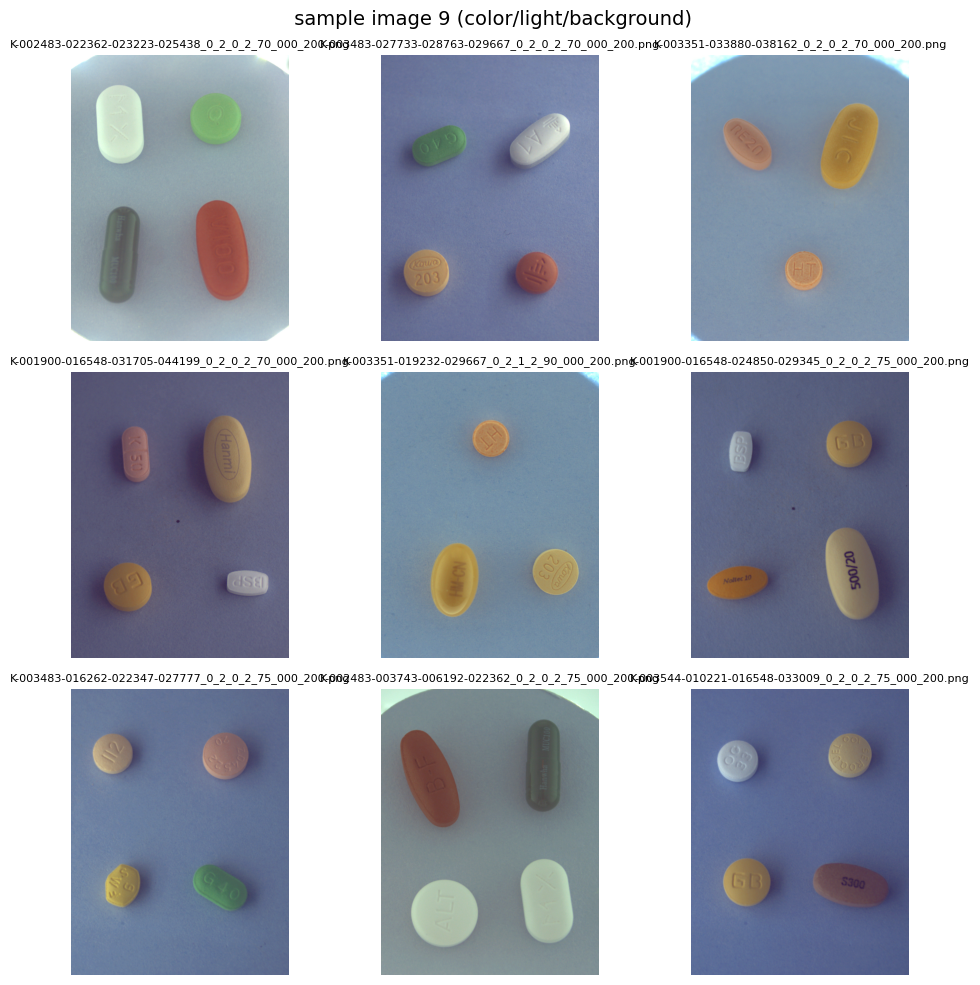

In [ ]:
# 시각화
fig, axes = plt.subplots(3, 3, figsize=(10, 10))

for i, ax in enumerate(axes.flat):
    img_path = os.path.join(img_dir, sample_files[i])
    img = Image.open(img_path)
    ax.imshow(img)
    ax.set_title(sample_files[i], fontsize=8)
    ax.axis('off')
plt.suptitle(" sample image 9 (color/light/background)", fontsize=14)
plt.tight_layout()
plt.show()

밝기 정규화 / 배경색 통일or제거(색감차이 정규화) 필요

1) 밝기 정규화

밝기 정규화 전

/tmp/ipython-input-50-1302673028.py:9: MatplotlibDeprecationWarning: Passing the range parameter of hist() positionally is deprecated since Matplotlib 3.9; the parameter will become keyword-only in 3.11.
  plt.hist(gray_orig.ravel(), 256, [0,256])


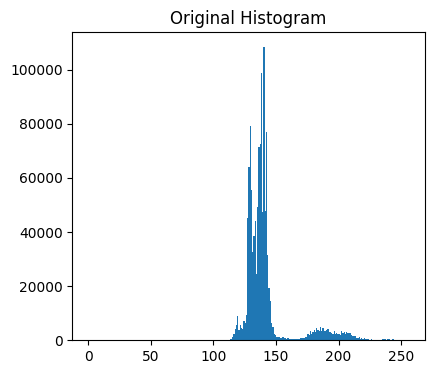

In [ ]:
from matplotlib import pyplot as plt
import cv2

# 정규화 전 이미지
img_orig = cv2.imread(img_path)
gray_orig = cv2.cvtColor(img_orig, cv2.COLOR_BGR2GRAY)
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.hist(gray_orig.ravel(), 256, [0,256])
plt.title("Original Histogram")
plt.show()

* X축 = 픽셀의 밝기
* 0은 검정색 255는 흰색 중간은 회색 -> 이미지 밝기가 120~150 내에 집중적 분포= 명암대비가 낮음

/tmp/ipython-input-51-3451979846.py:18: MatplotlibDeprecationWarning: Passing the range parameter of hist() positionally is deprecated since Matplotlib 3.9; the parameter will become keyword-only in 3.11.
  plt.hist(img.ravel(), 256, [0, 256])


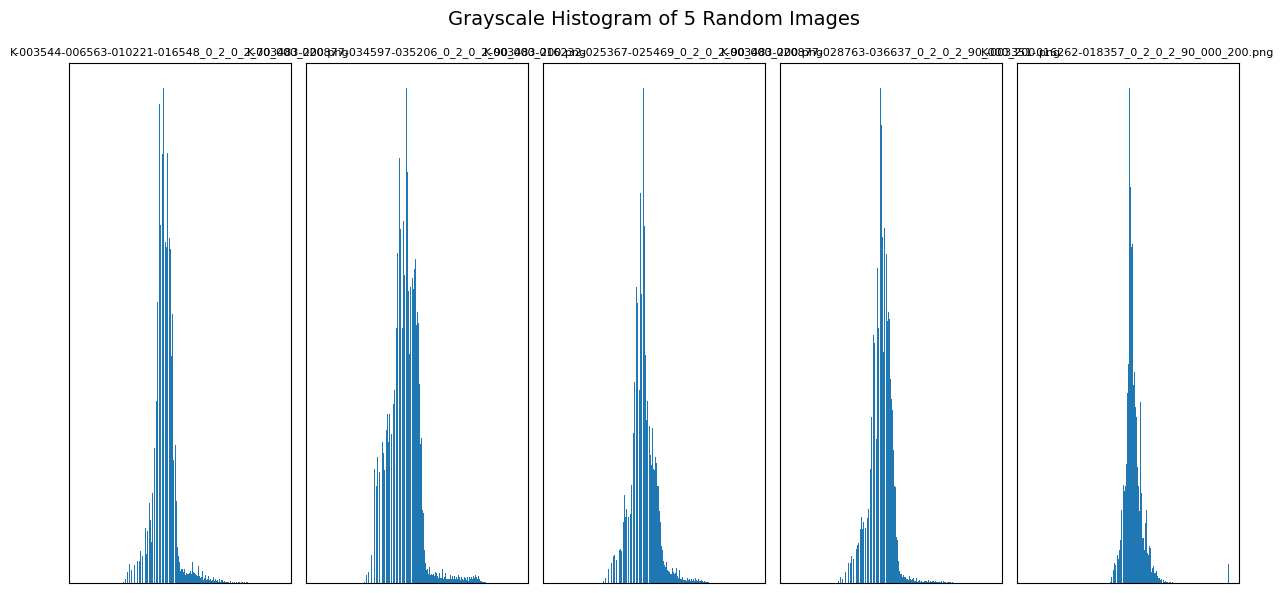

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import random

# 이미지 디렉토리와 샘플 수
img_dir = './train_images'
sample_files = random.sample([f for f in os.listdir(img_dir) if f.endswith('.png')], 5)

plt.figure(figsize=(12, 6))

# 히스토그램 5개 출력
for i, file in enumerate(sample_files):
    img_path = os.path.join(img_dir, file)
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    plt.subplot(1, 5, i+1)
    plt.hist(img.ravel(), 256, [0, 256])
    plt.title(f"{file}", fontsize=8)
    plt.xticks([])
    plt.yticks([])

plt.suptitle("Grayscale Histogram of 5 Random Images", fontsize=14)
plt.tight_layout()
plt.show()


명암대비가 낮지만 중간에 분포되어 대체로 회색톤이지만 밝기가 비슷하게 분포되어 있어서 밝기 정규화 필요 없어 보임!

2) 배경색 정규화

이미지 전체 색감 히스토그램으로 나타내기

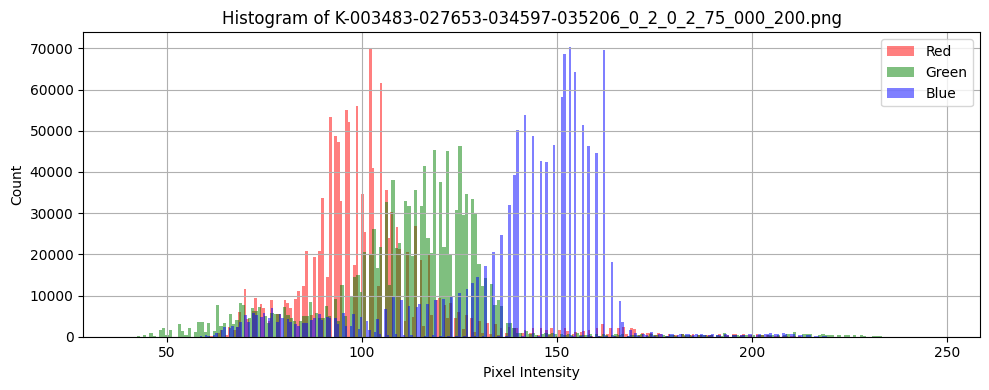

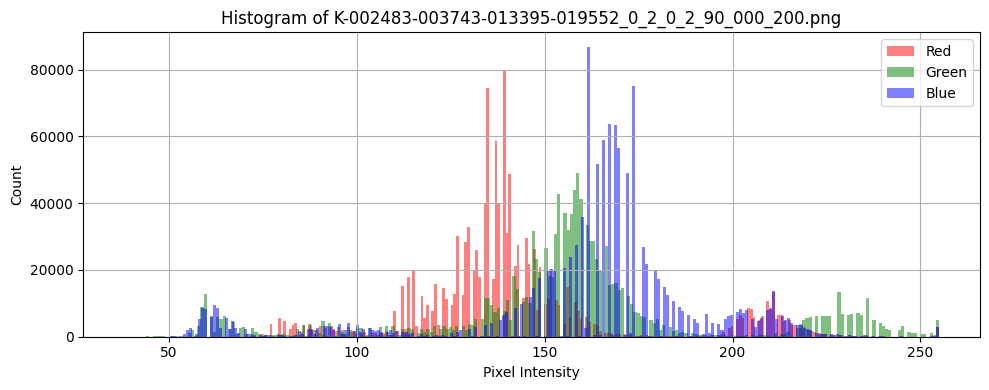

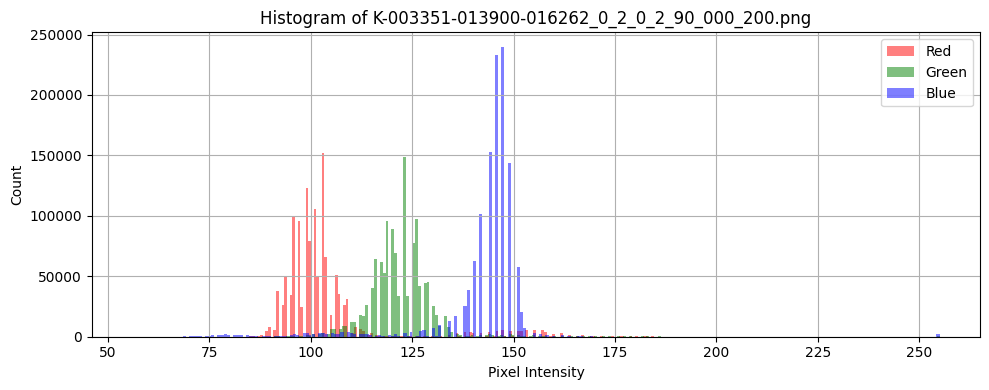

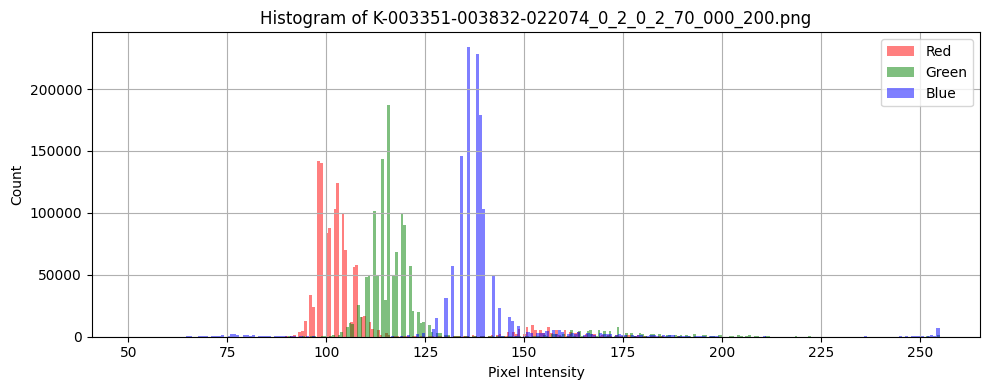

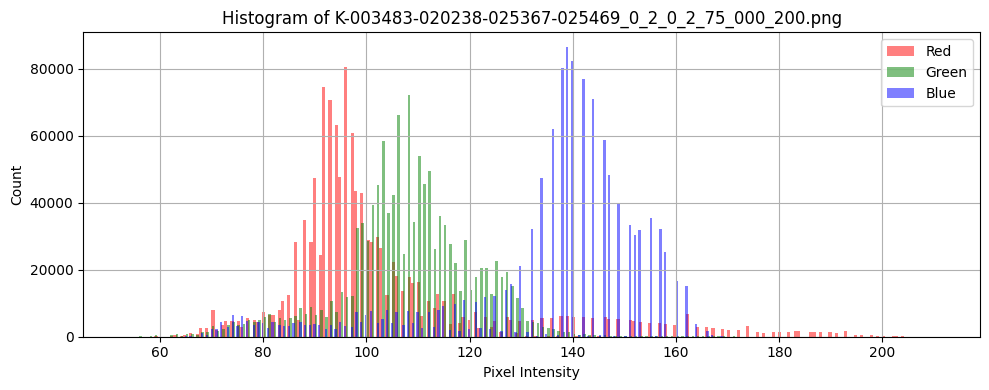

In [ ]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

# 이미지 디렉토리 설정
img_dir = './train_images'  # 본인 경로로 수정
image_files = [f for f in os.listdir(img_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

# 샘플 이미지 N장 무작위 선택
sample_files = random.sample(image_files, 5)

# 시각화
for file in sample_files:
    img_path = os.path.join(img_dir, file)
    img = Image.open(img_path).convert('RGB')
    img_np = np.array(img)

    # RGB 분리
    r, g, b = img_np[:, :, 0], img_np[:, :, 1], img_np[:, :, 2]

    # 히스토그램 계산
    plt.figure(figsize=(10, 4))
    plt.title(f"Histogram of {file}")
    plt.hist(r.ravel(), bins=256, color='red', alpha=0.5, label='Red')
    plt.hist(g.ravel(), bins=256, color='green', alpha=0.5, label='Green')
    plt.hist(b.ravel(), bins=256, color='blue', alpha=0.5, label='Blue')
    plt.legend()
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Count")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


히스토그램 중심값, 폭이 다 다름(이미지 마다 R/G/B분포 다름), 배경색 하늘/파랑 -> 배경색 정규화(통일) 필요

* 배경 기준 색상 보정하기

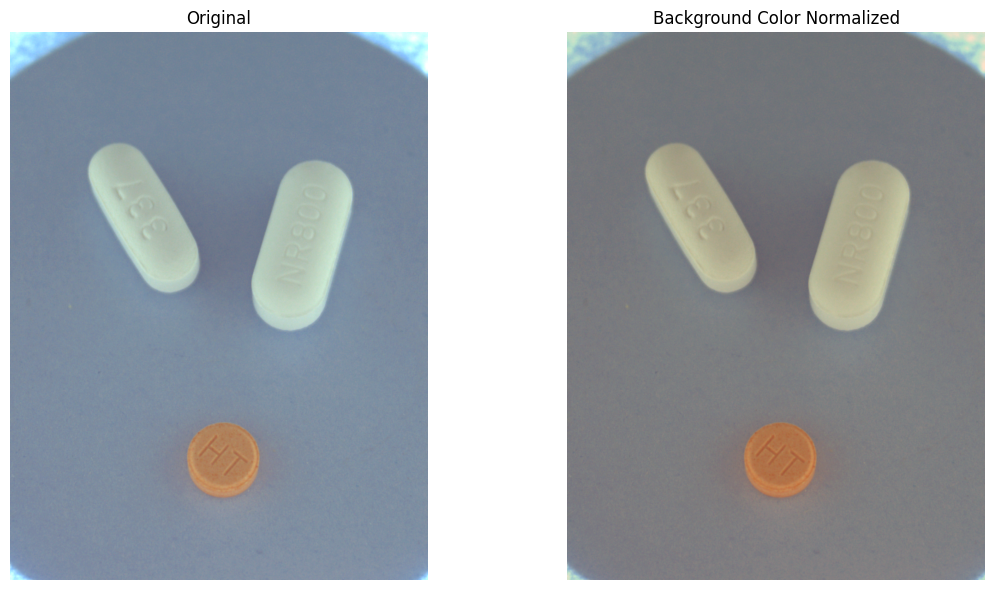

In [ ]:
import cv2
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from PIL import Image

# 배경 기준 정규화 타겟 (중간 회색)
target_bg_color = np.array([128, 128, 128])

# 예시 이미지 경로 & bbox 정보
image_path = './train_images/K-003351-003832-035206_0_2_0_2_70_000_200.png'

# 이미지 로드
img = cv2.imread(image_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# 예시 bbox: x_min, y_min, x_max, y_max
bbox_list = [[322, 336, 550, 432], [612, 338, 832, 437], [478, 610, 574, 671]]

# 배경 마스크 만들기
mask = np.ones(img.shape[:2], dtype=bool)  # True: 배경

for bbox in bbox_list:
    x_min, y_min, x_max, y_max = bbox
    mask[y_min:y_max, x_min:x_max] = False  # 객체 부분 False 처리

# 배경 영역 픽셀 추출
bg_pixels = img_rgb[mask]

# 배경 평균 색상 계산
bg_mean = np.mean(bg_pixels, axis=0)

# 정규화 비율 계산
scale = target_bg_color / bg_mean

# 전체 이미지 보정
img_corrected = img_rgb * scale
img_corrected = np.clip(img_corrected, 0, 255).astype(np.uint8)

# 시각화
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(img_rgb)
axes[0].set_title("Original")
axes[1].imshow(img_corrected)
axes[1].set_title("Background Color Normalized")
for ax in axes:
    ax.axis('off')
plt.tight_layout()
plt.show()


In [ ]:
df_annotations.to_csv("/mnt/data/train_annotations.csv", index=False)


In [82]:
df_annotations.to_csv("train_annotations.csv", index=False)

전체 이미지 색상 보정 적용

RGB 비교 코드